In [19]:
import fsspec
import cf_xarray
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xoak
from sklearn.neighbors import BallTree

In [20]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem(
    "reference", 
    fo='s3://nextgen-dmac-cloud-ingest/nos/ngofs2/nos.ngofs2.fields.best.nc.zarr', 
    remote_protocol='s3', 
    remote_options={'anon':True}, 
    target_protocol='s3', 
    target_options={'anon':True}
)
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={}, drop_variables=['Itime2'])
ds

<xarray.Dataset>
Dimensions:             (time: 237, four: 4, nele: 569405, node: 303714,
                         three: 3, maxnode: 10, maxelem: 8, siglev: 41,
                         siglay: 40)
Coordinates:
    lat                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    latc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    lon                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    lonc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    siglay              (siglay, node) float32 dask.array<chunksize=(40, 303714), meta=np.ndarray>
    siglev              (siglev, node) float32 dask.array<chunksize=(41, 303714), meta=np.ndarray>
  * time                (time) datetime64[ns] 2023-10-04T21:00:00 ... 2023-11...
Dimensions without coordinates: four, nele, node, three, maxnode, maxelem
Data variables: (12/41)
    Itime               (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    Times               (time) |S26 dask.array<chunksize=(1,), meta=np.ndarray>
    a1u                 (time, four, nele) float32 dask.array<chunksize=(1, 4, 569405), meta=np.ndarray>
    a2u                 (time, four, nele) float32 dask.array<chunksize=(1, 4, 569405), meta=np.ndarray>
    art1                (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
    art2                (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
    ...                  ...
    ww                  (time, siglay, nele) float32 dask.array<chunksize=(1, 40, 569405), meta=np.ndarray>
    x                   (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
    xc                  (time, nele) float32 dask.array<chunksize=(1, 569405), meta=np.ndarray>
    y                   (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
    yc                  (time, nele) float32 dask.array<chunksize=(1, 569405), meta=np.ndarray>
    zeta                (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                 CF-1.0
    CoordinateProjection:        init=nad83:4205
    CoordinateSystem:            GeoReferenced
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    River_Forcing:               THERE ARE 63 RIVERS IN THIS MODEL.\nRIVER IN...
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    ...                          ...
    Tidal_Forcing:               TIDAL ELEVATION FORCING IS OFF!
    history:                     model started at: 04/10/2023   21:15
    institution:                 School for Marine Science and Technology
    references:                  http://fvcom.smast.umassd.edu, http://codfis...
    source:                      FVCOM_4.3
    title:                       NGOFS2

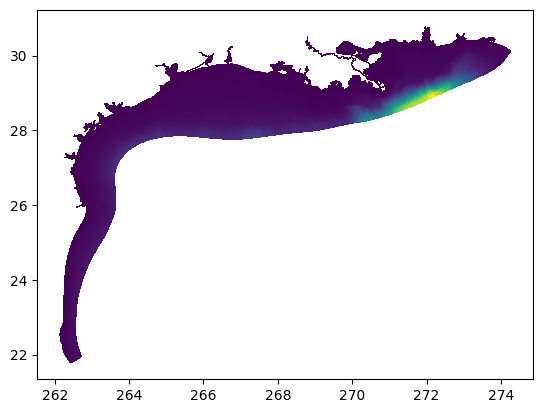

In [18]:
tris = tri.Triangulation(ds.lon, ds.lat, ds.nv.isel(time=0).T - 1)
plt.tripcolor(tris, ds.h.isel(time=0), shading='flat')

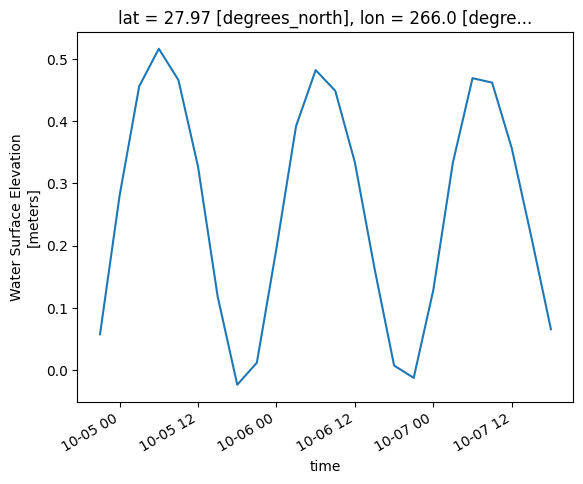

In [29]:
lng = np.deg2rad(ds.lon)
lat = np.deg2rad(ds.lat)

stacked = np.stack([lng, lat], axis=-1)
tree = BallTree(stacked, leaf_size=2)

target = [[np.deg2rad(266.0), np.deg2rad(28.0)]]
idx = tree.query(target, return_distance=False)

zeta = ds.zeta.isel(node=idx[0][0]).cf.isel(time=slice(0, 24))
zeta.plot()